## Sơ lược

- Mô hình AutoRec có hai dạng: **I-AutoRec** và **U-AutoRec**
- Ở đây ta xem xét **I-AutoRec**
- I-AutoRec (Item AutoRec) là một mô hình dựa trên kiến trúc AutoEncoder, thích hợp cho bài toán Collaborative filterning, chỉ thuần sử dụng dữ liệu đang có sẵn từ ma trận user-item interaction
- Ta đi vào ý tưởng:
  + Giả sử ta có ma trận user-item rating $R \in R^{m \times n}$. Mỗi user có thể biễu diễn bởi vector $r^{(u)} = (R_{u1},...,R_{un}) \in R^n$. Tương tự với item $r^{(i)} = (R_{1i}, ..., R_{mi}) \in R^m$.
  + Encode sẽ chiếu các vector $r^{(i)}$ xuống một không gian thấp chiều hơn (ở đây ta chọn 500), sau đó qua Decoder để xây dựng lại vector ban đầu, phù hợp cho mục tiêu dự đoán rating còn thiếu.
  + Ta định nghĩa **hàm tái xây dựng (reconstruct)** của input $r$
  $$h(r; \theta) = f(W\cdot g(Vr + \mu) + b)$$ \\
  với các tham số $\theta = \{W, V, \mu, b\}$ và $W \in R^{d \times k}, V \in R^{k \times d}, \mu \in R^k, b \in R^d$
  + Ta dùng **một hidden layer**
- Hàm Loss có dạng sau
$$min_{\theta} \sum_i ||r^{(i)} - h(r^{(i)};\theta)||^2_{O} + \frac{\lambda}{2}(||W||^2_F + ||V||^2_F)$$
  + Ở đây $||.||^2_O$ tức là observed (rating có sẵn), tức là ta chỉ update trọng số liên quan đến rating đó
  + Thành phần thứ hai là chuẩn hóa để tránh Overfitting
- Ta sử dụng I-AutoRec vì thường vector cho item ít sparse hơn vector cho user.

***Mô hình***


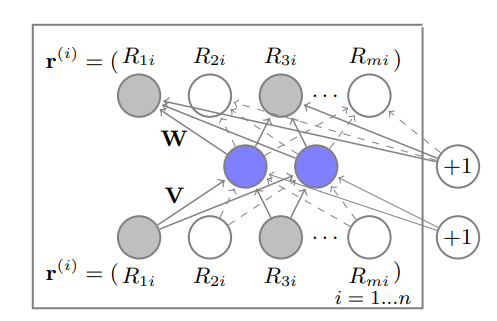
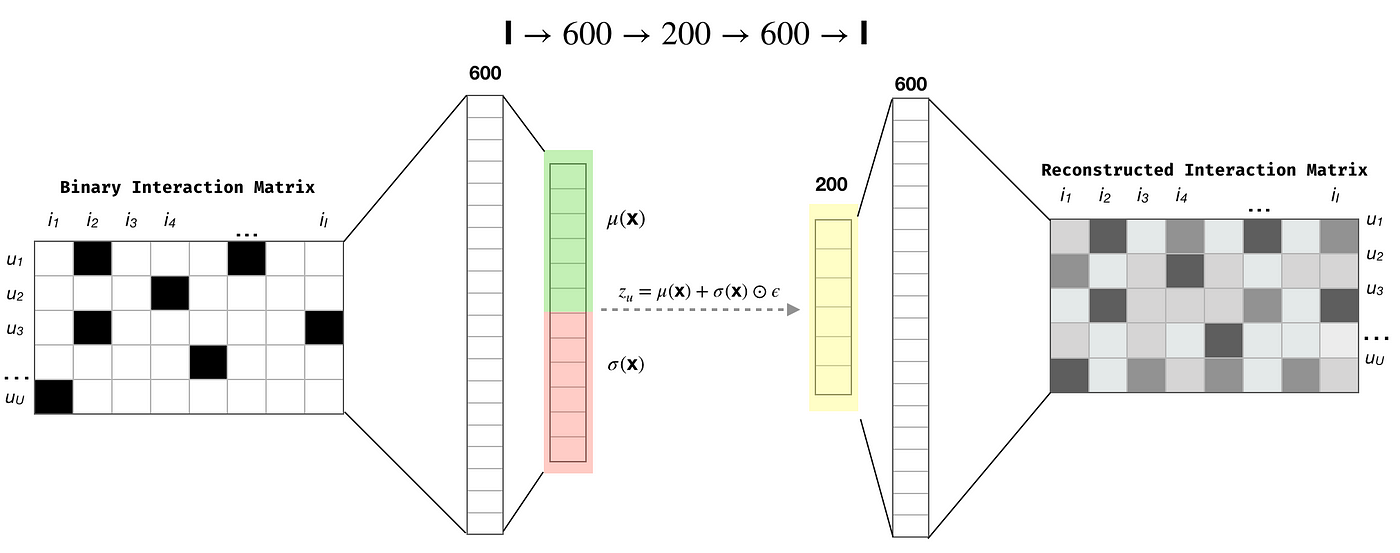

Như thể hiện ở hình, ta kỳ vọng ma trận reconstruct sẽ bớt sparse hơn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Hàm đọc dữ liệu và tạo ma trận

- Ở đây, ta tạo ma trận user-item R, thêm vào đó mask_R dùng để chỉ định những dữ liệu nào đang có sẵn (gán cho 1), gán cho 0 nếu ở đó chưa có dữ liệu (user và item chưa có tương tác), train_mask_R tương ứng index của dữ liệu trong tập train, test_mask_R tương ứng index của dữ liệu trong tập test
- Hàm này đọc dữ liệu từng dòng trong file ratings.dat, mà trong file này movie index lớn nhất là 3952, lớn hơn số lượng movie thực có (3883), nên sau khi có ma trận tái xây dựng (reconstruct) ta sẽ **mask những dữ liệu bị dư đó lại**

In [ ]:
import numpy as np

def read_rating(path, num_users, num_items,num_total_ratings, a, b, train_ratio):
    fp = open(path + "ratings.dat")

    user_train_set = set()
    user_test_set = set()
    item_train_set = set()
    item_test_set = set()

    R = np.zeros((num_users,num_items))
    mask_R = np.zeros((num_users, num_items))
    C = np.ones((num_users, num_items)) * b

    train_R = np.zeros((num_users, num_items))
    test_R = np.zeros((num_users, num_items))

    train_mask_R = np.zeros((num_users, num_items))
    test_mask_R = np.zeros((num_users, num_items))

    random_perm_idx = np.random.permutation(num_total_ratings)
    train_idx = random_perm_idx[0:int(num_total_ratings*train_ratio)]
    test_idx = random_perm_idx[int(num_total_ratings*train_ratio):]

    num_train_ratings = len(train_idx)
    num_test_ratings = len(test_idx)

    lines = fp.readlines()
    for line in lines:
        user,item,rating,_ = line.split("::")
        user_idx = int(user) - 1
        item_idx = int(item) - 1
        R[user_idx,item_idx] = int(rating)
        mask_R[user_idx,item_idx] = 1
        C[user_idx,item_idx] = a

    ''' Train '''
    for itr in train_idx:
        line = lines[itr]
        user,item,rating,_ = line.split("::")
        user_idx = int(user) - 1
        item_idx = int(item) - 1
        train_R[user_idx,item_idx] = int(rating)
        train_mask_R[user_idx,item_idx] = 1

        user_train_set.add(user_idx)
        item_train_set.add(item_idx)

    ''' Test '''
    for itr in test_idx:
        line = lines[itr]
        user, item, rating, _ = line.split("::")
        user_idx = int(user) - 1
        item_idx = int(item) - 1
        test_R[user_idx, item_idx] = int(rating)
        test_mask_R[user_idx, item_idx] = 1

        user_test_set.add(user_idx)
        item_test_set.add(item_idx)

    return R, mask_R, C, train_R, train_mask_R, test_R, test_mask_R,num_train_ratings,num_test_ratings,\
user_train_set,item_train_set,user_test_set,item_test_set

## Mô hình

- Khới tạo các tham số $W, V,\mu, b$ cũng như các tham số chuẩn hóa
- Khởi tạo các Encoder và Decoder
- test_model() in ra các lượt epoch, trong đó ta theo dõi metric RMSE (root mean square error), sai số giữa giá trị thực và dự đoán
- Sau khi train, ta trả về $\bf{estimated_R}$ là ma trận tái xây dựng, lưu vào file
result.npy
- make_records() lưu kết quả (metric RMSE) ta các file .txt

In [ ]:
import tensorflow.compat.v1 as tf
#tf.reset_default_graph()
#import tensorflow as tf
import time
import numpy as np
import os
import math

class AutoRec():
    def __init__(self,sess,args,
                      num_users,num_items,
                      R,
                      mask_R, C, train_R, train_mask_R, test_R, test_mask_R,num_train_ratings,num_test_ratings,
                      user_train_set, item_train_set, user_test_set, item_test_set,
                      result_path):

        self.sess = sess
        self.args = args

        self.num_users = num_users
        self.num_items = num_items

        self.R = R
        self.mask_R = mask_R
        self.C = C
        self.train_R = train_R
        self.train_mask_R = train_mask_R
        self.test_R = test_R
        self.test_mask_R = test_mask_R
        self.num_train_ratings = num_train_ratings
        self.num_test_ratings = num_test_ratings

        self.user_train_set = user_train_set
        self.item_train_set = item_train_set
        self.user_test_set = user_test_set
        self.item_test_set = item_test_set

        self.hidden_neuron = args.hidden_neuron
        self.train_epoch = args.train_epoch
        self.batch_size = args.batch_size
        self.num_batch = int(math.ceil(self.num_users / float(self.batch_size)))

        self.base_lr = args.base_lr
        self.optimizer_method = args.optimizer_method
        self.display_step = args.display_step
        self.random_seed = args.random_seed

        self.global_step = tf.Variable(0, trainable=False)
        self.decay_epoch_step = args.decay_epoch_step
        self.decay_step = self.decay_epoch_step * self.num_batch
        self.lr = tf.train.exponential_decay(self.base_lr, self.global_step,
                                                   self.decay_step, 0.96, staircase=True)
        self.lambda_value = args.lambda_value

        self.train_cost_list = []
        self.test_cost_list = []
        self.test_rmse_list = []

        self.result_path = result_path
        self.grad_clip = args.grad_clip
        super(AutoRec, self).__init__()

    def run(self):
        self.prepare_model()
        init = tf.global_variables_initializer()
        self.sess.run(init)
        for epoch_itr in range(self.train_epoch):
            self.train_model(epoch_itr)
            tmp = self.test_model(epoch_itr)
        self.make_records()

        np.save('result.npy', tmp)

    def prepare_model(self):
        self.input_R = tf.placeholder(dtype=tf.float32, shape=[None, self.num_items], name="input_R")
        self.input_mask_R = tf.placeholder(dtype=tf.float32, shape=[None, self.num_items], name="input_mask_R")

        V = tf.get_variable(name="V", initializer=tf.truncated_normal(shape=[self.num_items, self.hidden_neuron],
                                         mean=0, stddev=0.03),dtype=tf.float32)
        W = tf.get_variable(name="W", initializer=tf.truncated_normal(shape=[self.hidden_neuron, self.num_items],
                                         mean=0, stddev=0.03),dtype=tf.float32)
        mu = tf.get_variable(name="mu", initializer=tf.zeros(shape=self.hidden_neuron),dtype=tf.float32)
        b = tf.get_variable(name="b", initializer=tf.zeros(shape=self.num_items), dtype=tf.float32)

        pre_Encoder = tf.matmul(self.input_R,V) + mu
        self.Encoder = tf.nn.sigmoid(pre_Encoder)
        pre_Decoder = tf.matmul(self.Encoder,W) + b
        self.Decoder = tf.identity(pre_Decoder)

        pre_rec_cost = tf.multiply((self.input_R - self.Decoder) , self.input_mask_R)
        rec_cost = tf.square(self.l2_norm(pre_rec_cost))
        pre_reg_cost = tf.square(self.l2_norm(W)) + tf.square(self.l2_norm(V))
        reg_cost = self.lambda_value * 0.5 * pre_reg_cost

        self.cost = rec_cost + reg_cost

        if self.optimizer_method == "Adam":
            optimizer = tf.train.AdamOptimizer(self.lr)
        elif self.optimizer_method == "RMSProp":
            optimizer = tf.train.RMSPropOptimizer(self.lr)
        else:
            raise ValueError("Optimizer Key ERROR")

        if self.grad_clip:
            gvs = optimizer.compute_gradients(self.cost)
            capped_gvs = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gvs]
            self.optimizer = optimizer.apply_gradients(capped_gvs, global_step=self.global_step)
        else:
            self.optimizer = optimizer.minimize(self.cost, global_step=self.global_step)

    def train_model(self,itr):
        start_time = time.time()
        random_perm_doc_idx = np.random.permutation(self.num_users)

        batch_cost = 0
        for i in range(self.num_batch):
            if i == self.num_batch - 1:
                batch_set_idx = random_perm_doc_idx[i * self.batch_size:]
            elif i < self.num_batch - 1:
                batch_set_idx = random_perm_doc_idx[i * self.batch_size : (i+1) * self.batch_size]

            _, Cost = self.sess.run(
                [self.optimizer, self.cost],
                feed_dict={self.input_R: self.train_R[batch_set_idx, :],
                           self.input_mask_R: self.train_mask_R[batch_set_idx, :]})

            batch_cost = batch_cost + Cost
        self.train_cost_list.append(batch_cost)

        if (itr + 1) % self.display_step == 0:
            print ("Training //", "Epoch %d //" % (itr), " Total cost = {:.2f}".format(batch_cost),
               "Elapsed time : %d sec" % (time.time() - start_time))

    def test_model(self,itr, save_estimated_R = False, estimated_R_filename = None):
        start_time = time.time()
        Cost,Decoder = self.sess.run(
            [self.cost,self.Decoder],
            feed_dict={self.input_R: self.test_R,
                       self.input_mask_R: self.test_mask_R})

        self.test_cost_list.append(Cost)

        if (itr+1) % self.display_step == 0:
            Estimated_R = Decoder.clip(min=1, max=5)
            unseen_user_test_list = list(self.user_test_set - self.user_train_set)
            unseen_item_test_list = list(self.item_test_set - self.item_train_set)

            for user in unseen_user_test_list:
                for item in unseen_item_test_list:
                    if self.test_mask_R[user,item] == 1: # exist in test set
                        Estimated_R[user,item] = 3

            pre_numerator = np.multiply((Estimated_R - self.test_R), self.test_mask_R)
            numerator = np.sum(np.square(pre_numerator))
            denominator = self.num_test_ratings
            RMSE = np.sqrt(numerator / float(denominator))

            self.test_rmse_list.append(RMSE)

            print ("Testing //", "Epoch %d //" % (itr), " Total cost = {:.2f}".format(Cost), " RMSE = {:.5f}".format(RMSE),
                   "Elapsed time : %d sec" % (time.time() - start_time))
            print ("=" * 100)

        return Estimated_R


    def make_records(self):
        if not os.path.exists(self.result_path):
            os.makedirs(self.result_path)

        basic_info = self.result_path + "basic_info.txt"
        train_record = self.result_path + "train_record.txt"
        test_record = self.result_path + "test_record.txt"

        with open (train_record,'w') as f:
            f.write(str("Cost:"))
            f.write('\t')
            for itr in range(len(self.train_cost_list)):
                f.write(str(self.train_cost_list[itr]))
                f.write('\t')
            f.write('\n')

        with open (test_record,'w') as g:
            g.write(str("Cost:"))
            g.write('\t')
            for itr in range(len(self.test_cost_list)):
                g.write(str(self.test_cost_list[itr]))
                g.write('\t')
            g.write('\n')

            g.write(str("RMSE:"))
            for itr in range(len(self.test_rmse_list)):
                g.write(str(self.test_rmse_list[itr]))
                g.write('\t')
            g.write('\n')

        with open(basic_info,'w') as h:
            h.write(str(self.args))

    def l2_norm(self,tensor):
        return tf.sqrt(tf.reduce_sum(tf.square(tensor)))

## Chạy mô hình

Ở đây ta dùng lại các tham số như tác giả đề xuất

In [ ]:
import time
import numpy as np
#import argparse

tf.disable_v2_behavior()

current_time = time.time()

class Args:
    hidden_neuron = 500
    lambda_value = 1
    train_epoch = 2000
    batch_size = 100
    optimizer_method = 'Adam'
    grad_clip = False
    base_lr = 1e-3
    decay_epoch_step = 50
    random_seed = 1000
    display_step = 1

args = Args()

tf.set_random_seed(args.random_seed)
np.random.seed(args.random_seed)
num_users = 6040
num_items = 3952
num_total_ratings = 1000209
train_ratio = 0.9

path = "/content/drive/MyDrive/ml-1m/ml-1m/"
result_path = '/content/drive/MyDrive/ml-1m/ml-1m/results/' + str(args.random_seed) + '_' + str(args.optimizer_method) + '_' + str(args.base_lr) + "_" + str(current_time) + "/"

R, mask_R, C, train_R, train_mask_R, test_R, test_mask_R, num_train_ratings, num_test_ratings, \
user_train_set, item_train_set, user_test_set, item_test_set = read_rating(
    path, num_users, num_items, num_total_ratings, 1, 0, train_ratio)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

AutoRec_instance = AutoRec(sess, args, num_users, num_items, R, mask_R, C, train_R, train_mask_R, test_R, test_mask_R,
                            num_train_ratings, num_test_ratings, user_train_set, item_train_set, user_test_set,
                            item_test_set, result_path)
tf.compat.v1.disable_eager_execution()
AutoRec_instance.run()


Instructions for updating:
non-resource variables are not supported in the long term


Streaming output truncated to the last 5000 lines.
Testing // Epoch 333 //  Total cost = 76048.41  RMSE = 0.85579 Elapsed time : 0 sec
Training // Epoch 334 //  Total cost = 233223.32 Elapsed time : 0 sec
Testing // Epoch 334 //  Total cost = 76523.36  RMSE = 0.85860 Elapsed time : 0 sec
Training // Epoch 335 //  Total cost = 232794.91 Elapsed time : 0 sec
Testing // Epoch 335 //  Total cost = 75904.45  RMSE = 0.85495 Elapsed time : 0 sec
Training // Epoch 336 //  Total cost = 231967.71 Elapsed time : 0 sec
Testing // Epoch 336 //  Total cost = 76025.02  RMSE = 0.85569 Elapsed time : 0 sec
Training // Epoch 337 //  Total cost = 231414.93 Elapsed time : 0 sec
Testing // Epoch 337 //  Total cost = 75442.22  RMSE = 0.85233 Elapsed time : 0 sec
Training // Epoch 338 //  Total cost = 232846.47 Elapsed time : 0 sec
Testing // Epoch 338 //  Total cost = 76119.09  RMSE = 0.85627 Elapsed time : 0 sec
Training // Epoch 339 //  Total cost = 234218.61 Elapsed time : 0 sec
Testing // Epoch 339 //  

$\Rightarrow$ Ta chỉ in ra RMSE của tập test, có thể thấy nó dần kẹt ở 0.84

# Lưu kết quả và sử dụng

Đường dẫn

In [ ]:
path = "/content/drive/MyDrive/ml-1m/ml-1m/"

In [ ]:
result = np.load('/content/result.npy')

Lưu lại

In [ ]:
file_path = f'{path}/reconstruct_matrix.txt'
np.savetxt(file_path, result)

Load ma trận tái xây dựng lên

In [ ]:
reconstruct = np.loadtxt(file_path)
reconstruct

array([[2.05537057, 2.85118723, 2.87562132, ..., 3.22851372, 3.6208725 ,
        3.2833221 ],
       [1.85387123, 2.62713337, 2.4866569 , ..., 3.09219265, 3.8447063 ,
        3.43140006],
       [1.88371432, 2.53390741, 2.69906187, ..., 3.31548834, 3.70916152,
        3.37142158],
       ...,
       [1.67649221, 2.39748144, 2.25489044, ..., 3.1161654 , 3.47654152,
        3.2418437 ],
       [1.77264547, 2.73916006, 1.89779723, ..., 3.1459012 , 3.66674566,
        3.63577175],
       [1.68924391, 2.52789259, 2.67636919, ..., 3.12587452, 3.40449023,
        3.25236082]])

Làm tròn các giá trị thực về giá trị nguyên

In [ ]:
rounded = [[round(element) for element in row] for row in reconstruct]
rounded

Đọc dữ liệu

In [ ]:
import pandas as pd
movies_df = pd.read_csv(f'{path}/movies.dat',

                      delimiter='::', engine= 'python', header=None,encoding = 'latin-1',
                        names=['movie_id','movie_name', 'genre'])
movies_df.head()

In [ ]:
readme_text = np.array(open(f'{path}/README').read().splitlines())
start_index = np.flatnonzero(np.core.defchararray.find(readme_text,'Occupation is chosen')!=-1)[0]
end_index = np.flatnonzero(np.core.defchararray.find(readme_text,'MOVIES FILE DESCRIPTION')!=-1)[0]
occupation_list = [x.split('"')[1] for x in readme_text[start_index:end_index][2:-1].tolist()]
occupation_dict = dict(zip(range(len(occupation_list)), occupation_list))

users_df = pd.read_csv(f'{path}/users.dat',
                       delimiter='::', engine='python', header=None,encoding = 'latin-1',
                       names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])
users_df['occupation'] = users_df['occupation'].replace(occupation_dict)
users_df.head()

In [ ]:
ratings_df = pd.read_csv(f'{path}/ratings.dat',
                         delimiter='::', engine='python', header=None,encoding = 'latin-1',
                         names=['user_id', 'movie_id', 'rating', 'time'])
ratings_df.head()

Như đã đê cập ở trước, ma trận reconstruct có số lượng item lớn hơn số item gốc (do cách đọc file ratings), nên ta sẽ lấy các index bị dư trong dữ liệu phim (movies_df), ánh xạ nó qua ma trận reconstruct và xóa những cột đó đi (gán cho 0)


In [ ]:
min_movie_id = movies_df['movie_id'].min()
max_movie_id = movies_df['movie_id'].max()

all_movie_ids = list(range(min_movie_id, max_movie_id + 1))
missing_ids = set(all_movie_ids) - set(movies_df['movie_id'])

print("Missing movie IDs:", missing_ids)

Missing movie IDs: {1536, 1540, 646, 1800, 1418, 1802, 1803, 1808, 1530, 1813, 1048, 1560, 1786, 1435, 1691, 1818, 1182, 1823, 1700, 677, 1828, 1576, 1195, 1451, 1452, 686, 1838, 1072, 689, 817, 1074, 1712, 1338, 1469, 323, 1478, 1607, 1736, 1481, 1737, 1229, 1745, 1618, 1491, 1492, 1239, 1751, 91, 221, 1505, 1506, 995, 740, 1634, 1637, 1638, 1512, 1761, 1763, 1766, 3815, 622, 1775, 1521, 1778, 883, 1402, 1403, 1790}


In [ ]:
missing_ids = np.array(list(missing_ids))
missing_ids

array([1536, 1540,  646, 1800, 1418, 1802, 1803, 1808, 1530, 1813, 1048,
       1560, 1786, 1435, 1691, 1818, 1182, 1823, 1700,  677, 1828, 1576,
       1195, 1451, 1452,  686, 1838, 1072,  689,  817, 1074, 1712, 1338,
       1469,  323, 1478, 1607, 1736, 1481, 1737, 1229, 1745, 1618, 1491,
       1492, 1239, 1751,   91,  221, 1505, 1506,  995,  740, 1634, 1637,
       1638, 1512, 1761, 1763, 1766, 3815,  622, 1775, 1521, 1778,  883,
       1402, 1403, 1790])

Đây là những index bị dư

In [ ]:
missing_ids = missing_ids - 1
missing_ids

array([1535, 1539,  645, 1799, 1417, 1801, 1802, 1807, 1529, 1812, 1047,
       1559, 1785, 1434, 1690, 1817, 1181, 1822, 1699,  676, 1827, 1575,
       1194, 1450, 1451,  685, 1837, 1071,  688,  816, 1073, 1711, 1337,
       1468,  322, 1477, 1606, 1735, 1480, 1736, 1228, 1744, 1617, 1490,
       1491, 1238, 1750,   90,  220, 1504, 1505,  994,  739, 1633, 1636,
       1637, 1511, 1760, 1762, 1765, 3814,  621, 1774, 1520, 1777,  882,
       1401, 1402, 1789])

Chuyển ma trận reconstruct ở trên về dạng numpy array và tiến hành mask những index bị dư

In [ ]:
rounded = np.array(rounded)
rounded[:, missing_ids] = 0

Tất cả đã xong, giờ ta đề xuất phim cho user 200

In [ ]:
users_df[users_df['user_id'] == 200]

,user_id,gender,age,occupation,zip_code
199,200,F,18,college/grad student,84321


User này là một sinh viên nữ, độ tuổi là 18

Ta lấy hàng thứ 199 (tương ứng user_id 200), sắp xếp giá trị (tức là rating) từ cao đến thấp, lấy ra 10 giá trị cao nhất

In [ ]:
sorted_indices = np.argsort(rounded[199])[::-1][:10]
sorted_indices

array([3381, 3171, 3606, 3409,   52,  786, 2904, 3244, 3880, 3655])

In [ ]:
import warnings
warnings.filterwarnings('ignore')
df = pd.DataFrame(columns=['movie_id', 'genre'])
for id in sorted_indices:
    df = df.append(movies_df[movies_df['movie_id'] == id], ignore_index=True)
df

,movie_id,genre,movie_name
0,3381,Comedy|Drama,Slaves to the Underground (1997)
1,3171,Drama,Room at the Top (1959)
2,3606,Musical,On the Town (1949)
3,3409,Drama|Thriller,Final Destination (2000)
4,52,Comedy,Mighty Aphrodite (1995)
5,786,Action|Thriller,Eraser (1996)
6,2904,Drama,Rain (1932)
7,3244,Comedy|Romance,"Goodbye Girl, The (1977)"
8,3880,Documentary,"Ballad of Ramblin' Jack, The (2000)"
9,3655,Drama,Blow-Out (La Grande Bouffe) (1973)


$\Rightarrow$ Kết quả hợp lý nếu xét theo góc độ một nữ sinh 18 tuổi, với các thể loại chủ yếu là **Drama**